In [1]:
from __future__ import division # integer division now yields floating-point numbers

import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
import pandas as pd
from skimage.io import imread, imsave   # image processing
from scipy.optimize import curve_fit
from scipy.stats import *       # stats utils
from scipy.signal import correlate, correlate2d, fftconvolve

import cv2
import re

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

%load_ext line_profiler

In [2]:
from sonar import Sonar
import utils

didson = Sonar();
didson.load_config('../data/DIDSON/didson.json')
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise
print 'RX gain:', didson.rx_gain,'dB'

Pings are 96 beams by 512 bins
Field of view: 0.502862655531
Range: 2.25  -  11.25 m.
Noise: 0.002
RX gain: 20.0 dB


In [5]:
root = '/home/pvt/workspace/projects/project-hauv/post/2018-03-15.01/pings/'
images = sorted(glob(root+'*raw_polar.png')) # window set to 2.25m to 11.25m
configs = sorted(glob(root+'*.json'))

print len(images),'image files,',len(configs),'config files'
N = len(images)

output_path =  'output/pre-processing/cmm-sparse-dev/2018-03-15.01/'
idx = 6000
M = 3000

# takes 2-3 hours to run through the entire set, about 6-7 minutes for 3k images

10881 image files, 10881 config files


In [4]:
root = '/home/pvt/workspace/projects/project-hauv/post/2018-03-14.00/pings/'
images = sorted(glob(root+'*raw_polar.png')) # window set to 2.25m to 11.25m
configs = sorted(glob(root+'*.json'))

print len(images),'image files,',len(configs),'config files'
N = len(images) 
idx = 6000
M = 3000

output_path =  'output/cmm-sparse-map/2018-03-14.00/'

levels=2**8


0 image files, 0 config files


In [6]:
def get_template(dr=9.0/512, l=-10.0):
    r = np.arange(0,1,dr)
    pulse = np.exp(l*r)
    return pulse

def find_pulse(signal, pulse):
    q = np.correlate(signal, pulse, mode='full')
    q = np.copy(q[len(pulse)-1:])
    return np.argmax(q)

# def compute_q(ping, pulse):
#     q = 
    
def extract_ranges(ping, threshold, pulse):
    # detect occupied beams
    occ = utils.detect(ping, threshold)

    ranges = -1*np.ones_like(occ)
    # TODO: operate on full image at once
    for i in range(0, len(occ)):
        if occ[i]:
            ranges[i] = find_pulse(ping[:,i], pulse)
#     ranges[ranges<0] = np.nan
    return ranges  

def reconstruct(ping, ranges, pulse):
    ping2 = np.zeros_like(ping)
    for i in range(0, len(ranges)):
        if ranges[i]>0:
            ping2[ranges[i],i] = 1.0
#             ping2[ranges[i]:(ranges[i]+len(pulse)),i]=pulse
    return ping2

NameError: name 'pulse' is not defined

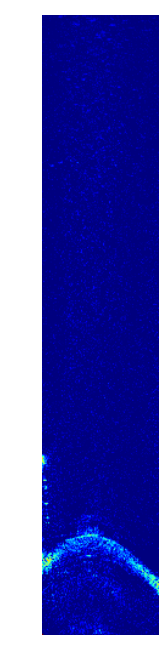

In [10]:
idx = np.random.randint(len(images))
ping_raw = imread(images[idx], as_grey = True).astype(np.float64) # 1 ms
ping_raw /= (levels-1.0)
didson.load_config(configs[idx])               # < 1ms
bg =1.0

# 1. Pre-processing
ping_raw_cart = didson.to_cart(ping_raw, bg) # 6 ms
# cv2.imwrite(output_path + filename+'_raw_cart.png',(255*ping_raw_cart).astype(np.uint8)) # 8 ms
ping = didson.preprocess(ping_raw, True) 
plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(ping)
plt.axis('off')

pulse.shape = (len(pulse),1)
# q = correlate(ping, pulse, mode='full')

qr = fftconvolve(ping, pulse[::-1], mode='full') # 2ms
qr = np.copy(qr[(len(pulse)-1):,:])

qr[qr < 1]= -1
print ping.shape
print qr.shape

print len(pulse)
plt.subplot(1,3,2)
plt.imshow(qr)
plt.axis('off')
plt.colorbar()

print q.shape
mq = np.argmax(qr, axis=0)
mp = np.argmax(ping, axis=0)

plt.subplot(1,3,3)
ps = np.zeros_like(ping)
print 'ps:',ps.shape
for i in range(0,96):
    ps[mq[i],i] = 255.0
plt.imshow(ps,cmap='gray')
plt.axis('off')

plt.figure()
plt.plot(mp,'.',label='ping')
plt.plot(mq,'.',label='q')
plt.grid()
plt.legend()

# plt.ylim([300,400])
print mp[0],mq[0]

## Sparse MAP

In [13]:
levels=2**8
bg = 1.0
threshold = 0.4 # energy threshold

# create template:
dr = 9/512
r = np.arange(0,1,dr)
pulse = np.exp(-10*r)

offset = 512
# R = np.zeros((96, M+offset))
R = np.zeros((96, M))
fns = re.compile(r"[0-9]{16}")

# count = np.zeros(M)
# didson.load_config(configs[0])
for i in range(0, M):
    filename = fns.findall(images[idx+i])[0]         # < 1us
    ping_raw = imread(images[idx+i], as_grey = True).astype(np.float64) # 1 ms
    ping_raw /= (levels-1.0)
    didson.load_config(configs[idx+i])               # < 1ms
    
    # 1. Pre-processing
    ping_raw_cart = didson.to_cart(ping_raw, bg) # 6 ms
    cv2.imwrite(output_path + filename+'_raw_cart.png',(255*ping_raw_cart).astype(np.uint8)) # 8 ms
    ping = didson.preprocess(ping_raw, True)           # 3-5 ms
    ping_cart = didson.to_cart(ping, bg)          # 4-6 ms
    cv2.imwrite(output_path + filename+'_pre_cart.png',(255*ping_cart).astype(np.uint8)) # 8 ms per loop
    
    ranges = extract_ranges(ping, threshold, pulse)
    ping_r = reconstruct(ping, ranges, pulse)
    ranges_cart = didson.to_cart(ping_r, bg)
    cv2.imwrite(output_path + filename+'_sparse_map_cart.png',(255*ranges_cart).astype(np.uint8)) # 8 ms per loop
 
    R[:,i] = ranges

#     R[:,i+offset-1] = ranges
#     rng = R[:,i:(i+offset)] # may have to flip upside down to be consistent!
#     imsave(output_path+filename+'_rng.png',255*rng.astype(np.uint8)) # range image

#     ping_r = reconstruct(ping, ranges, pulse)
#     imsave(output_path+filename+'_sem.png',(255*np.rot90(ping_r,k=3)).astype(np.uint8))

#     d = utils.detect(ping, threshold)
#     ping_rgb = utils.annotate(ping, d)
#     count[i] = np.sum(d)

#     imsave(output_path+filename+'_raw.png',(255*np.rot90(ping_raw,k=3)).astype(np.uint8))
#     imsave(output_path+filename+'_pre.png',(255*np.rot90(ping,k=3)).astype(np.uint8))
#     imsave(output_path+filename+'_occ.png',(255*np.rot90(ping_rgb,k=3)).astype(np.uint8))

In [12]:
output_path

'output/pre-processing/cmm-sparse-dev/2018-03-15.01/'

In [ ]:
rc = np.copy(R)
print rc.min(), rc.max()
print rc.shape
rc[rc<=0]=np.nan
rc*=9.0/512
rc+=2.25 
print rc.min(), rc.max()

plt.figure(figsize=(12,1))
plt.imshow(rc)
plt.axis('off')
cv2.imwrite(output_path+'range_image.png', rc)
np.savetxt(output_path+'range.csv', rc, delimiter=',', newline='\n')
plt.imsave(output_path+'range_plot.png',rc,vmin=0,vmax=12)



---

---

---

## Transition function

In [ ]:
# compute transition function from R
rc = np.copy(R[:,offset-1:-1])
print rc.shape
# print rc[:,-1]
rc[rc<=0]=np.nan

diffs = []

for i in range(0,M):
    d = np.diff(rc[:,i])
    d = np.abs(d[~np.isnan(d)]) # remove NaNs and compute absolute difference
    diffs = np.append(diffs, d)
    
bins = np.linspace(0,9.0,512)
hist, _ = np.histogram((9.0/512.0)*diffs, bins)

p_dr = hist/np.sum(hist)
c_dr = np.cumsum(p_dr)

plt.figure()
plt.subplot(1,2,1)
plt.plot(bins[:-1],p_dr)
plt.yscale('log')
# plt.xscale('log')

plt.grid()
plt.xlabel(r'$\delta_r$')
plt.subplot(1,2,2)
plt.plot(bins[:-1],c_dr)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel(r'$\delta_r$')

df = pd.DataFrame({'dr':bins[:-1],'p':hist/np.sum(hist)})
df.to_csv('didson-transition-ship.csv', index=False)

In [ ]:
tm[tm<=0]=np.nan
d = np.diff(tm)
print np.abs(d)
d = np.abs(d[~np.isnan(d)])
print d.shape

In [ ]:
a = np.zeros(5)
a[2] = np.nan
print np.diff(a)

In [ ]:
images = sorted(glob('/home/pvt/data/pings/raw/*.png')) # window set to 2.25m to 11.25m
configs = sorted(glob('/home/pvt/data/pings/raw/*.json'))
i = np.random.randint(len(images))
ping_raw = imread(images[i], as_grey = True).astype(np.float64) 
ping_raw/=255.0
#     didson.load_config(configs[idx+i])
didson.noise = 0.002
ping = didson.deconvolve(ping_raw)

dr = 9/512
r = np.arange(0,1,dr)
pulse = np.exp(-10*r)
pulse /= np.sum(pulse)

plt.grid()

plt.plot(ping[:,48],label='ping')
plt.plot(pulse,linewidth=2)

# CONVOLUTION
# q = np.convolve(ping[:,48], pulse,mode='full')
# q = np.copy(q[1:-len(pulse)+2])
# print q.shape

# CORRELATION

q = np.correlate(ping[:,48], pulse,mode='full')
print q.shape
q = np.copy(q[len(pulse)-1:])
print q.shape


# plt.figure()
plt.plot(q, linewidth=2)

print np.argmax(ping[:,48])
print np.argmax(q)
plt.ylim([0,1])

# 